In [1]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [2]:
# Import MlFinLab tools
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
from mlfinlab.sampling import concurrent, bootstrapping
from mlfinlab.util import multiprocess, volatility

## 4.1 In Chapter 3. we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents.

### 4.1 (a) Compute a t1 series on dollar bars derived from e-mini S&P 500 futures tick data

In [3]:
# Read in data
# data = pd.read_csv('official_data/dollar_bars.csv', nrows=40000)
data = pd.read_csv('../Sample-Data/dollar_bars.csv')

data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
close_prices = data['close']

In [7]:
print(close_prices.head())
print(close_prices.describe())
print('\nNo of NANs: {:}'.format(close_prices.isna().sum()))

date_time
2015-01-01 23:00:23.723    2056.75
2015-01-02 07:07:35.156    2064.00
2015-01-02 09:35:57.204    2060.50
2015-01-02 12:59:42.176    2061.00
2015-01-02 14:19:33.847    2063.75
Name: close, dtype: float64
count    24079.000000
mean      2061.126864
std         88.690949
min       1805.750000
25%       2013.750000
50%       2073.250000
75%       2114.250000
max       2272.000000
Name: close, dtype: float64

No of NANs: 0


In [8]:
# Compute daily volatility
vol = volatility.get_daily_vol(close=close_prices, lookback=50)

In [9]:
vol

date_time
2015-01-04 23:20:12.567         NaN
2015-01-05 03:37:42.912    0.001036
2015-01-05 08:21:37.801    0.001010
2015-01-05 10:27:41.882    0.000817
2015-01-05 12:42:45.989    0.000701
                             ...   
2016-12-30 20:59:58.848    0.002397
2016-12-30 21:00:00.352    0.002350
2016-12-30 21:00:24.294    0.002304
2016-12-30 21:03:03.027    0.002261
2016-12-30 21:13:31.990    0.002228
Name: close, Length: 24039, dtype: float64

In [10]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(close_prices, threshold=vol.mean())

In [11]:
cusum_events

DatetimeIndex(['2015-01-02 15:39:14.826000', '2015-01-02 20:47:02.488000',
               '2015-01-04 23:20:12.567000', '2015-01-05 14:49:36.175000',
               '2015-01-05 16:10:05.172000', '2015-01-05 19:53:07.211000',
               '2015-01-06 15:22:16.841000', '2015-01-06 15:57:59.243000',
               '2015-01-06 16:35:18.127000', '2015-01-06 18:20:27.201000',
               ...
               '2016-12-14 20:58:28.022000', '2016-12-15 14:59:27.415000',
               '2016-12-16 16:22:41.095000', '2016-12-19 16:05:39.052000',
               '2016-12-22 14:36:05.103000', '2016-12-27 14:35:26.243000',
               '2016-12-28 15:01:29.826000', '2016-12-28 20:41:52.086000',
               '2016-12-30 15:29:57.978000', '2016-12-30 19:55:31.030000'],
              dtype='datetime64[ns]', length=1524, freq=None)

In [12]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, close_prices, num_days=1)
vertical_barriers.head()

2015-01-02 15:39:14.826   2015-01-04 23:20:12.567
2015-01-02 20:47:02.488   2015-01-04 23:20:12.567
2015-01-04 23:20:12.567   2015-01-06 02:16:54.528
2015-01-05 14:49:36.175   2015-01-06 14:52:04.655
2015-01-05 16:10:05.172   2015-01-06 16:11:27.929
Name: date_time, dtype: datetime64[ns]

In [13]:
triple_barrier_events = labeling.get_events(close=close_prices,
                                            t_events=cusum_events,
                                            pt_sl=[1, 1],
                                            target=vol,
                                            min_ret=0.01,
                                            num_threads=1,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=None)

In [14]:
triple_barrier_events.head()

,t1,trgt,pt,sl
2015-01-09 17:13:19.851,2015-01-11 23:31:19.054,0.010065,1,1
2015-01-15 13:45:55.324,2015-01-15 14:57:17.741,0.010148,1,1
2015-01-15 14:39:34.621,2015-01-16 00:15:15.421,0.010703,1,1
2015-01-30 10:09:09.112,2015-02-01 23:26:29.558,0.011492,1,1
2015-01-30 14:48:27.262,2015-01-30 20:54:46.692,0.010769,1,1


### 4.1 (b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time

In [15]:
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent.num_concurrent_events,
                                             ('molecule', triple_barrier_events.index), num_threads, 
                                            close_series_index=close_prices.index,
                                             label_endtime=triple_barrier_events['t1'])

In [16]:
# Eliminate the duplicates
num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep='last')]

# Reindex based on the close prices
num_conc_events = num_conc_events.reindex(close_prices.index).fillna(0)
len(num_conc_events)

24079

### 4.1 (c) Plot the time-series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis 

In [17]:
display_df = (pd.DataFrame().assign(vol=vol,
                                    num_conc_events=num_conc_events)
                            .drop_duplicates()
                            .dropna())

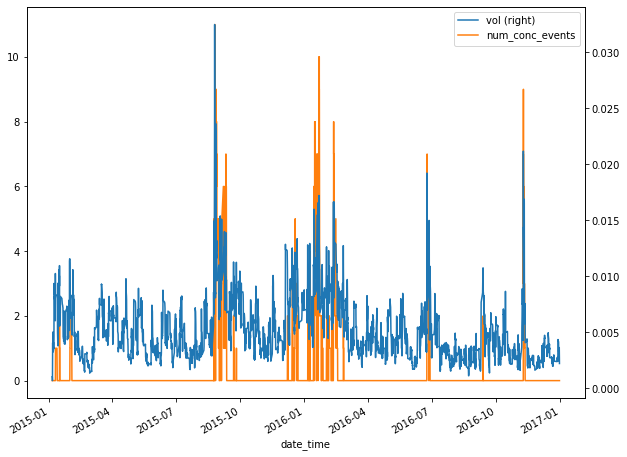

In [18]:
# display_df.plot()
display_df[['vol', 'num_conc_events']].plot(secondary_y='vol', figsize=(10,8))
plt.show()

### 4.1 (d) Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate the relationship?

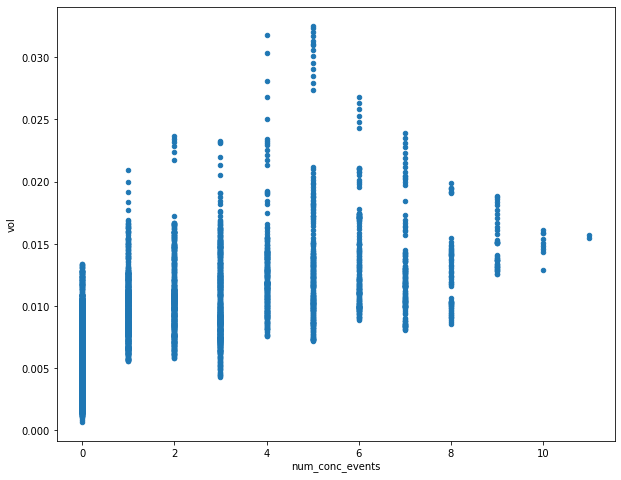

In [19]:
display_df.plot.scatter(x='num_conc_events', y='vol', figsize=(10, 8))
plt.show()

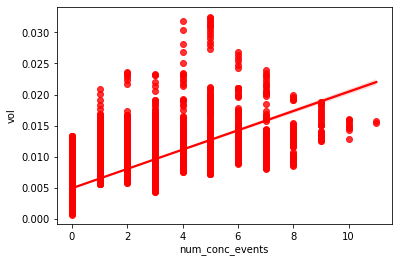

In [20]:
sns.regplot(x=display_df['num_conc_events'], y=display_df['vol'], color='r')
plt.show()

In [21]:
# Try polyfit
x = display_df['num_conc_events']
y = display_df['vol']
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

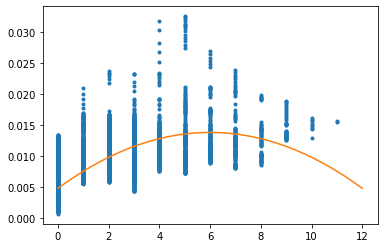

In [22]:
xp = np.linspace(0, max(x)+1, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')

## 4.2 Using thefunction mpSampleTW, compute the average uniqueness of each label. What is the first-order serial correlation, AR(1), of this time series? Is it statistically significant? Why? 

In [23]:
out = multiprocess.mp_pandas_obj(concurrent._get_average_uniqueness, ('molecule', triple_barrier_events.index), num_threads, 
                                 label_endtime=triple_barrier_events['t1'], num_conc_events=num_conc_events)

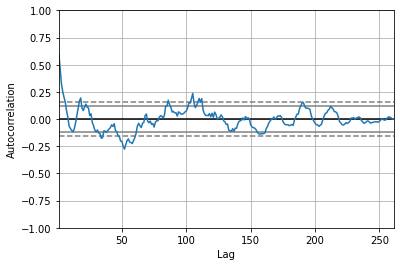

In [24]:
# ACF plot
pd.plotting.autocorrelation_plot(out);

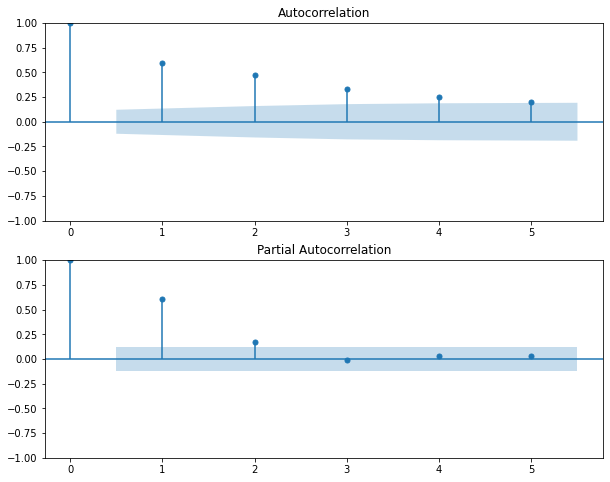

In [25]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plot_acf(out, ax=plt.gca(), lags=5)
plt.subplot(212)
plot_pacf(out, ax=plt.gca(), lags=5)
plt.show()

*The ACF chart shows the auocorrelation of average uniqueness of labels. The fact that the series is statistically significant at lags 1 and 2 indicate that uniqueness persists over time.  4.1.(c) shows that number of concurrent events are mostly zero except when volatility spikes. When the number of concurrent events is zero, then uniqueness is high. This means that we can expect autocorrelation at some level. Here it is at lags 1 and 2.*

## 4.3 Fit a random forest to a financial data set where the average uniqueness is de minimis   

In [26]:
# Read in data

data = pd.read_csv('../Sample-Data/dollar_bars.csv')

data.index = pd.to_datetime(data['date_time'])
data = data.drop('date_time', axis=1)
data = data.loc['2015-02-03':'2015-08-31']
close_prices = data['close']

### 4.3 (a) What is the mean out-of-bag accuracy?

##### Define RSI 

In [27]:
# Compute RSI
def relative_strength_index(df, n):
        """
        Calculate Relative Strength Index(RSI) for given data.
        https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py
        
        :param df: (pd.DataFrame) Frame of data to use.
        :param n: (int) RST to use.
        :return: (pd.DataFrame) Resulting RSI.
        """

        i = 0
        UpI = [0]
        DoI = [0]

        while i + 1 <= df.index[-1]:
            UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
            DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
            if UpMove > DoMove and UpMove > 0:
                UpD = UpMove
            else:
                UpD = 0
            UpI.append(UpD)
            if DoMove > UpMove and DoMove > 0:
                DoD = DoMove
            else:
                DoD = 0
            DoI.append(DoD)
            i = i + 1

        UpI = pd.Series(UpI)
        DoI = pd.Series(DoI)
        PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
        NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
        RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
        # df = df.join(RSI)

        return RSI

def get_rsi(data, window=14):
    """
    Wrapper around the relative_strength_index function.
    """
    
    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)

    return rsi_df

##### define Bollinger bands

In [28]:
def bbands(close_prices, window, no_of_stdev):
    """
    Apply Bollinger Bands to the series.
    """
    
    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [29]:
# Compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=1.5)
data.sample(10)

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower
date_time,,,,,,,,,,
2015-08-11 16:47:32.944,2078.00,2079.00,2075.75,2076.50,33789,70198557.00,2915,2083.716377,2095.832046,2071.600708
2015-07-06 15:12:49.759,2065.75,2066.25,2062.75,2062.75,33905,70001247.25,3341,2061.460471,2073.001464,2049.919478
2015-05-18 18:41:34.658,2126.50,2127.00,2125.25,2126.50,33094,70358913.25,3392,2118.179096,2127.235961,2109.122230
2015-02-13 18:24:12.312,2088.00,2089.50,2087.25,2087.50,33523,70006255.00,11132,2083.787886,2096.354768,2071.221003
2015-08-24 03:02:39.153,1930.50,1934.50,1923.25,1932.00,36330,70118139.50,8111,1973.700787,2004.381109,1943.020465
2015-04-09 13:58:49.464,2074.25,2075.00,2072.50,2074.75,33753,70006021.50,4098,2073.815741,2080.252834,2067.378648
2015-05-27 15:53:59.313,2116.50,2117.75,2116.00,2117.25,33258,70405884.50,3390,2109.411701,2120.273678,2098.549723
2015-05-04 18:38:21.707,2110.50,2112.00,2109.25,2111.50,33166,70013906.75,4081,2103.202770,2118.858957,2087.546583
2015-08-13 20:07:20.029,2080.00,2081.25,2079.75,2080.25,33813,70347921.75,2181,2079.759561,2090.932748,2068.586374


In [30]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [31]:
# Compute sides
data['side'] = np.nan 

long_signals = (data['close'] <= data['lower']) 
short_signals = (data['close'] >= data['upper']) 

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead bias by lagging the signal
data['side'] = data['side'].shift(1)

 1.0    340
-1.0    251
Name: side, dtype: int64


In [32]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
print(data.side.value_counts())

 1.0    339
-1.0    251
Name: side, dtype: int64


In [34]:
# Compute daily volatility
daily_vol = volatility.get_daily_vol(close=data['close'], lookback=50)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol['2011-09-01':'2018-01-01'].mean() * 0.1)

# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)

In [35]:
pt_sl = [0, 2]
min_ret = 0.0005
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            min_ret=min_ret,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side'])

2021-11-28 16:52:26.198755 100.0% apply_pt_sl_on_t1 done after 0.21 minutes. Remaining 0.0 minutes.


In [36]:
# Averge uniqueness
avg_uniqueness = concurrent.get_av_uniqueness_from_triple_barrier(triple_barrier_events, close_prices, num_threads=1)
print(avg_uniqueness.mean())

tW    0.247968
dtype: float64


In [37]:
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

 1.0    208
-1.0    125
Name: side, dtype: int64

### Features

In [38]:
# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 50
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 50

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()


In [39]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1

In [40]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower'] 
short_signals = raw_data['close'] >= raw_data['upper'] 

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1

In [41]:
# Remove look ahead bias
raw_data = raw_data.shift(1)
raw_data.head()

,open,high,low,close,cum_vol,cum_dollar,cum_ticks,avg,upper,lower,...,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
date_time,,,,,,,,,,,,,,,,,,,,,
2015-02-03 15:02:12.773,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:07:20.968,2032.25,2034.50,2031.75,2032.25,34432.0,70002102.75,13165.0,2026.365845,2035.969525,2016.762165,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:14:10.455,2032.25,2032.50,2030.00,2031.25,34466.0,70003717.00,10916.0,2026.790317,2036.190829,2017.389805,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:21:15.748,2031.25,2031.50,2028.00,2029.50,34497.0,70012124.50,11723.0,2027.015090,2036.072304,2017.957877,...,NaN,NaN,-0.000492,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-03 15:27:12.943,2029.50,2030.75,2027.50,2030.00,34501.0,70005857.25,11184.0,2027.252318,2036.015327,2018.489310,...,NaN,NaN,-0.000862,-0.000492,NaN,NaN,NaN,NaN,NaN,NaN


#### Now get the data at the specified events

In [42]:
# Get features at event dates
X = raw_data.loc[labels.index, :]

# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'cum_vol', 'cum_dollar', 'cum_ticks','fast_mavg', 'slow_mavg',], axis=1, inplace=True)

y = labels['bin']

### Fit a model

In [43]:
# Split data into training, validation and test sets
X_training_test = X
y_training_test = y
X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)

In [44]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

1    143
0    123
Name: bin, dtype: int64

##### Note that true positives (1) are a less than 25% of the false positives (0).  We would want to rebalance the class weights to pay more attention to true positives (and less to false positives)

In [45]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [46]:
# extract parameters
n_estimator = 100
depth = 5
c_random_state = 42
print(n_estimator, depth, c_random_state)

100 5 42


In [47]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))

Out-of-bag Accuracy (OOB Score): 0.687970


/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


##### *The out of bag accuracy in a data-set that has low uniqueness is very high (81%) ... commenting on observations with low uniquness, section 4.5 of AFML, page 63 states, "random sampling will make out-of-bag examples very similar to in-the-bag ones, the OOB accuracy would be grossly inflated"*  

### 4.3 (b) what is the mean accuracy of k-fold cross-validation (without shuffling) on the same dataset?

In [48]:
# K-fold
no_of_folds = 5
kfold = KFold(shuffle=True, random_state=1, n_splits=no_of_folds)
print(kfold)

KFold(n_splits=5, random_state=1, shuffle=True)


In [49]:
accuracy_array = np.zeros(no_of_folds)
i = 0
for train_index, test_index in kfold.split(X_training_test):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train.values.ravel())

    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    accuracy_array[i] = accuracy_score(y_test, y_pred)
    i += 1
    # print(accuracy_score(y_test, y_pred))

/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
/Users/junwei1/opt/anaconda3/envs/mlfinlab/lib/python3.8/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature n

In [50]:
print(accuracy_array)
print("Mean KFold accuracy: {:.6f}".format(np.mean(accuracy_array)))

[0.67164179 0.7761194  0.65671642 0.60606061 0.74242424]
Mean KFold accuracy: 0.690592


##### *The mean accuracy from KFold is 79% - 2 percentatge point lower than OOB accuracy score. The OOB score is more biased because in case of sampling with replacement, there is higher redundancy within the in-the-bag observations. This in turn causes overestimation of accuracy.*